# Introducción

Este documento ha sido creado para la realización del TFG del estudiante David Pastor Crespo, el cual pertenece al Grado en Ingeniería Informática de la Universidad de alicante.

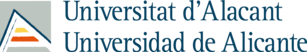

# Preparación del entorno

## Conexión con Google Drive

Para probar el modelo, este se guardará en Google Drive con el objetivo de que todos los resultados sean guardados en este almacenamiento.

In [ ]:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  HOME='/content/drive/MyDrive'
  %cd $HOME

## Clonar el repositorio de GitHub

Se clonará el repositorio de GitHub para su uso desde Google Colab, de modo que todas las pruebas podrán realizarse desde aquí.

In [ ]:
import os
tfg_dir = "tfg_david" #@param {type:"string"}
exists = os.path.isdir('$tfg_dir')
if not exists:
  %mkdir -p $tfg_dir
  %cd $HOME/$tfg_dir
  !git clone https://github.com/davidpc99/TFG.git
%cd $HOME/$tfg_dir/TFG/nlp

## Instalación de los requisitos

In [ ]:
!pip install -r requirements.txt

# Datasets

## Obtención de los Datasets

Se descargarán los conjuntos de datos necesarios para la realización del entrenamiento y comprobaciones del modelo. Para ello, se descargarán los DataSets de HuggingFace de Wikiann y se guardarán en formato de texto en "data". Cabe mencionar que las lenguas seleccionadas tienen que estar en formato ISO 639-1, por lo que en caso de querer el de francés se usará "fr". Además, cuando haya que usar varias lenguas se separarán por comas.

In [ ]:
%cd $HOME/$tfg_dir/TFG/nlp
"""Paso de los datasets de Wikiann a formato txt.
Se encontrarán en data/$directory/"""

#@markdown ### Datasets de Wikiann necesarios
language1 = "fr" #@param {type:"string"}
language2 = "es" #@param {type:"string"}

#@markdown ### Nombre de las carpetas donde guardar los datasets
data_dir1 = "french" #@param {type:"string"}
data_dir2 = "french-spanish" #@param {type:"string"}

!python loadDataset.py $data_dir1 $language1
!python loadDataset.py $data_dir2 $language2

## Concatencación del training

A continuación, se concatenarán los sets de entrenamiento de los dos idiomas en el segundo directorio. De esta forma, se obtiene un conjunto de entrenamiento en francés-español en el segundo directorio.

In [ ]:
%cp -rf $HOME/$tfg_dir/TFG/nlp/data/$data_dir1/test/ $HOME/$tfg_dir/TFG/nlp/data/$data_dir2/
%cp -rf $HOME/$tfg_dir/TFG/nlp/data/$data_dir1/val/ $HOME/$tfg_dir/TFG/nlp/data/$data_dir2/
%cat $HOME/$tfg_dir/TFG/nlp/data/$data_dir1/train/sentences.txt >> $HOME/$tfg_dir/TFG/nlp/data/$data_dir2/train/sentences.txt
%cat $HOME/$tfg_dir/TFG/nlp/data/$data_dir1/train/labels.txt >> $HOME/$tfg_dir/TFG/nlp/data/$data_dir2/train/labels.txt

# Construción de los **vocabularios**





Se construirá el vocabulario del conjunto de datos a partir de las oraciones guardadas en el directorio seleccionado anteriormente.

## Vocabulario del primer conjunto

In [ ]:
%cd $HOME/$tfg_dir/TFG/nlp
!python build_vocab.py --data_dir data/$data_dir1

## Vocabulario del segundo conjunto

In [ ]:
%cd $HOME/$tfg_dir/TFG/nlp
!python build_vocab.py --data_dir data/$data_dir2

# Entrenamiento del modelo

## Creación del directorio y los parámetros del entrenamiento

Para realizar el entrenamiento del modelo es necesario crear o usar un directorio en que guardar las métricas de entrenamiento (se encontrará en "experiments"). En caso de que el directorio no contenga un fichero params.json habrá que subirlo (ejecutando el siguiente código) y deberá tener una estructura como la disponible en "experiments/base_model/params.json". **El fichero debe llamarse params.json**.


In [ ]:
#@markdown ### Directorio en el que entrenar el modelo
experiment_dir1 = "french" #@param {type:"string"}
experiment_dir2 = "french-spanish" #@param {type:"string"}

%cd $HOME/$tfg_dir/TFG/nlp/experiments
exists = os.path.exists('$experiment_dir1')
if not exists:
  %mkdir -p $experiment_dir1
exists = os.path.exists('$experiment_dir2')
if not exists:
  %mkdir -p $experiment_dir2
%cd $HOME/$tfg_dir/TFG/nlp/experiments/$experiment_dir1
exists = os.path.exists('params.json')
if not exists:
  from google.colab import files
  uploaded = files.upload()
  filename = next(iter(uploaded))
%cd $HOME/$tfg_dir/TFG/nlp/experiments/$experiment_dir2
exists = os.path.exists('params.json')
if not exists:
  %cp $HOME/$tfg_dir/TFG/nlp/experiments/$experiment_dir1/params.json params.json

## Realización del entrenamiento

En este apartado se realizará el entrenamiento de ambos modelos y se guardarán los resultados en sus respectivos directorios.

### Modelo monolingüe

In [ ]:
%cd $HOME/$tfg_dir/TFG/nlp
!python train.py --data_dir data/$data_dir1 --model_dir experiments/$experiment_dir1


### Modelo multilingüe

In [ ]:
%cd $HOME/$tfg_dir/TFG/nlp
!python train.py --data_dir data/$data_dir2 --model_dir experiments/$experiment_dir2

## Visualización del entrenamiento

In [ ]:
%cd $HOME/$tfg_dir/TFG/nlp/experiments/$experiment_dir1
import matplotlib.pyplot as plt
import numpy as np

with open('train_accuracy.txt', 'r') as f:
  train_accuracy = [float(row) for row in f]
with open('validation_accuracy.txt', 'r') as f:
  validation_accuracy = [float(row) for row in f]

epoch_list = [item for item in range(1, len(train_accuracy)+1)]
xaxis = np.array(epoch_list)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('Monolingual model')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.plot(xaxis, np.array(train_accuracy), label="Train Set")
ax1.plot(xaxis, np.array(validation_accuracy), label="Validation Set")
ax1.set_ylim(ymin=0.6)
ax1.legend()

%cd $HOME/$tfg_dir/TFG/nlp/experiments/$experiment_dir2

with open('train_accuracy.txt', 'r') as f:
  train_accuracy = [float(row) for row in f]
with open('validation_accuracy.txt', 'r') as f:
  validation_accuracy = [float(row) for row in f]

ax2.set_title('Multilingual model')
ax2.set(xlabel='Epoch', ylabel='Accuracy')
ax2.plot(xaxis, np.array(train_accuracy), label="Train Set")
ax2.plot(xaxis, np.array(validation_accuracy), label="Validation Set")
ax2.set_ylim(ymin=0.6)
ax2.legend()
plt.show()

## Visualización de la tasa de aprendizaje del scheduler

In [ ]:
%cd $HOME/$tfg_dir/TFG/nlp/experiments/$experiment_dir1
import matplotlib.pyplot as plt
import numpy as np

with open('scheduler.txt', 'r') as f:
  scheduler = [float(row) for row in f]

epoch_list = [item for item in range(1, len(train_accuracy)+1)]
xaxis = np.array(epoch_list)
yaxis = np.array(scheduler)
plt.figure("Scheduler")
plt.title("Scheduler learning rate")
plt.xlabel("Epoch")
plt.ylabel("Learning rate")
plt.plot(xaxis, yaxis)
plt.show()



# Evaluación del modelo

## Evaluación monolingüe

In [ ]:
%cd $HOME/$tfg_dir/TFG/nlp
!python evaluate.py --data_dir data/$data_dir1 --model_dir experiments/$experiment_dir1

## Evaluación multilingüe

In [ ]:
%cd $HOME/$tfg_dir/TFG/nlp
!python evaluate.py --data_dir data/$data_dir2 --model_dir experiments/$experiment_dir2

# Borrado de la carpeta

En caso de querer borrar la carpeta del TFG de drive para realizar los experimentos desde cero, se deberá ejecutar la siguiente celda de código:

In [ ]:
%cd $HOME
%rm -rf /$HOME/$tfg_dir